# Orlen fuel prices analysis
The project aims to compare wholesale fuel prices offered in Poland with brent crude oil purchase prices and the USD/PLN exchange rate. The aim is to determine changes in fuel prices on the Polish market in relation to economic changes, and to determine whether there are periods when fuel prices did not correlate with other factors affecting them.

In [1]:
import pandas as pd 
import os
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from datetime import datetime, timedelta
import numpy as np

load_dotenv()

True

## 1. Downloading data

In [2]:
# Downloading historical brent oil price data from a csv file
brent = pd.read_csv('Brent od 01-01-2014.csv')  
brent

,Data,Ostatnio,Otwarcie,Max.,Min.,Wol.,Zmiana%
0,17.01.2024,"78,03","77,78","78,14","76,52",NaN,"-0,33%"
1,16.01.2024,"78,29","78,43","79,40","77,60","298,55K","0,18%"
2,15.01.2024,"78,15","78,14","78,90","76,85","177,69K","-0,18%"
3,12.01.2024,"78,29","78,75","80,75","77,96","401,34K","1,14%"
4,11.01.2024,"77,41","76,70","79,10","76,66","396,77K","0,79%"
...,...,...,...,...,...,...,...
2589,07.01.2014,"107,35","107,03","107,72","106,88","188,20K","0,58%"
2590,06.01.2014,"106,73","106,80","107,96","106,58","181,82K","-0,15%"
2591,03.01.2014,"106,89","107,88","108,64","106,79","191,13K","-0,83%"
2592,02.01.2014,"107,78","111,00","111,35","107,65","200,65K","-2,83%"


In [3]:
# Downloading USD exchange rate histyory data from a CSV file
USD = pd.read_csv('USD_01-01-2014-2024.csv')
USD

,Tabela,Data,Kurs średni,Zmiana
0,12/A/NBP/2024,2024-01-17,4.0434,0.19
1,11/A/NBP/2024,2024-01-16,4.0358,0.99
2,10/A/NBP/2024,2024-01-15,3.9963,0.55
3,9/A/NBP/2024,2024-01-12,3.9746,0.17
4,8/A/NBP/2024,2024-01-11,3.9680,0.06
...,...,...,...,...
2529,5/A/NBP/2014,2014-01-09,3.0695,-0.07
2530,4/A/NBP/2014,2014-01-08,3.0717,0.09
2531,3/A/NBP/2014,2014-01-07,3.0688,0.56
2532,2/A/NBP/2014,2014-01-03,3.0517,0.67


In [4]:
# Downloading data on wholesale ON prices from the lotos.pl website.
# URL of the fuel prices page
url = 'https://www.lotos.pl/145/type,oil_eurodiesel/dla_biznesu/hurtowe_ceny_paliw/archiwum_cen_paliw'

# Setting the date range
start_date = datetime(2014, 1, 1)
end_date = datetime(2023, 12, 31)

# Function to retrieve and process data
def scrape_fuel_prices(url, start_date, end_date):
    data = []
    
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    table = soup.find('table')
    rows = table.find_all('tr')[1:]  

    for row in rows:
        cols = row.find_all('td')
        date_str = cols[0].text.strip()
        price = cols[1].text.strip()  
        
        date = datetime.strptime(date_str, '%Y-%m-%d')
        
        if start_date <= date <= end_date:
            data.append({'date': date, 'price': price})

    df = pd.DataFrame(data)
    return df

diesel_prices = scrape_fuel_prices(url, start_date, end_date)

In [5]:
diesel_prices

,date,price
0,2023-12-30,"4 965,00"
1,2023-12-29,"5 009,00"
2,2023-12-28,"5 049,00"
3,2023-12-23,"5 082,00"
4,2023-12-22,"5 090,00"
...,...,...
2504,2014-01-08,"4 146,00"
2505,2014-01-04,"4 143,00"
2506,2014-01-03,"4 160,00"
2507,2014-01-02,"4 196,00"


## 2. Data unification

In [6]:
# Standardize the date format of collected data
brent['Data'] = pd.to_datetime(brent["Data"])
USD['Data'] = pd.to_datetime(USD["Data"])
diesel_prices['Data'] = pd.to_datetime(diesel_prices["date"], format='%d.%m.%Y')

C:\Users\MariuszKamiński\AppData\Local\Temp\ipykernel_16732\1196889892.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  brent['Data'] = pd.to_datetime(brent["Data"])


In [7]:
# Merging DataFrames
merged_df = pd.merge(brent, USD, on='Data', how='inner')
merged_df = pd.merge(merged_df, diesel_prices, left_on='Data', right_on='Data', how='inner')
merged_df.head()

,Data,Ostatnio,Otwarcie,Max.,Min.,Wol.,Zmiana%,Tabela,Kurs średni,Zmiana,date,price
0,2023-12-29,"77,04","77,38","77,98","76,73","192,95K","-1,72%",251/A/NBP/2023,3.9350,0.92,2023-12-29,"5 009,00"
1,2023-12-28,"78,39","79,80","79,95","78,25","18,78K","-1,58%",250/A/NBP/2023,3.8990,-0.48,2023-12-28,"5 049,00"
2,2023-12-22,"79,07","79,35","80,37","78,88","119,19K","-0,40%",248/A/NBP/2023,3.9338,-0.77,2023-12-22,"5 090,00"
3,2023-12-21,"79,39","79,00","80,13","77,81","193,32K","-0,39%",247/A/NBP/2023,3.9645,0.30,2023-12-21,"5 082,00"
4,2023-12-20,"79,70","79,17","80,60","79,07","241,81K","0,59%",246/A/NBP/2023,3.9527,-0.16,2023-12-20,"5 039,00"


In [8]:
# Removal of unnecessary columns
merged_df = merged_df.drop(columns=['Otwarcie', 'Max.', 'Min.', 'Wol.', 'Zmiana%', 'Tabela', 'Zmiana', 'date'])
merged_df.head()

,Data,Ostatnio,Kurs średni,price
0,2023-12-29,"77,04",3.9350,"5 009,00"
1,2023-12-28,"78,39",3.8990,"5 049,00"
2,2023-12-22,"79,07",3.9338,"5 090,00"
3,2023-12-21,"79,39",3.9645,"5 082,00"
4,2023-12-20,"79,70",3.9527,"5 039,00"


In [9]:
# Renaming columns
merged_df = merged_df.rename(columns={'Ostatnio': 'Brent USD/b',
                                      'Kurs średni': 'PLN/USD',
                                      'price': 'Eurodiesel'})
merged_df.set_index('Data', inplace=True)
merged_df.head()
merged_df.dtypes

Brent USD/b     object
PLN/USD        float64
Eurodiesel      object
dtype: object

In [10]:
# Change decimal separators from ',' to '.', change data type from int to float, remove white spaces
merged_df['Brent USD/b'] = merged_df['Brent USD/b'].str.replace(',', '.').str.replace(' ', '').astype(float)
merged_df['Eurodiesel'] = merged_df['Eurodiesel'].str.replace(',', '.').str.replace(' ', '').astype(float)
merged_df.dtypes

Brent USD/b    float64
PLN/USD        float64
Eurodiesel     float64
dtype: object

In [11]:
are_any_cells_empty = merged_df.isna().any().any()
print("Czy są jakieś puste komórki w DataFrame:", are_any_cells_empty)


Czy są jakieś puste komórki w DataFrame: False


In [12]:
merged_df

,Brent USD/b,PLN/USD,Eurodiesel
Data,,,
2023-12-29,77.04,3.9350,5009.0
2023-12-28,78.39,3.8990,5049.0
2023-12-22,79.07,3.9338,5090.0
2023-12-21,79.39,3.9645,5082.0
2023-12-20,79.70,3.9527,5039.0
...,...,...,...
2014-01-10,107.25,3.0700,4136.0
2014-01-09,106.39,3.0695,4150.0
2014-01-08,107.15,3.0717,4146.0


## 3. Data analysis

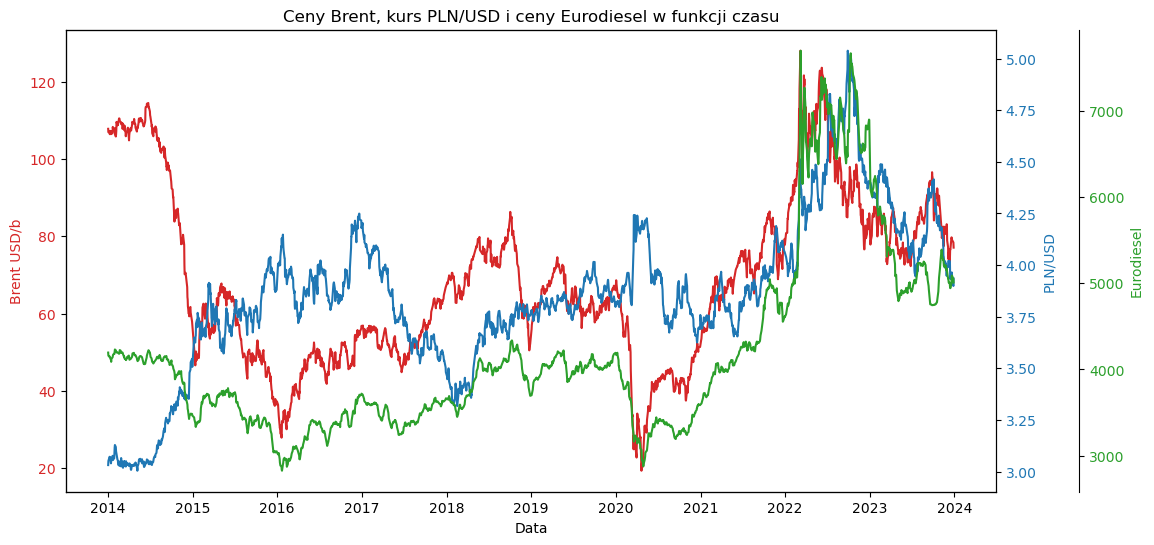

In [13]:
# Create a summary chart of the data
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Brent USD/b', color=color)
ax1.plot(merged_df['Brent USD/b'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('PLN/USD', color=color)  
ax2.plot(merged_df['PLN/USD'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))      
ax3.set_ylabel('Eurodiesel', color=color)
ax3.plot(merged_df['Eurodiesel'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Ceny Brent, kurs PLN/USD i ceny Eurodiesel w funkcji czasu')

plt.show()

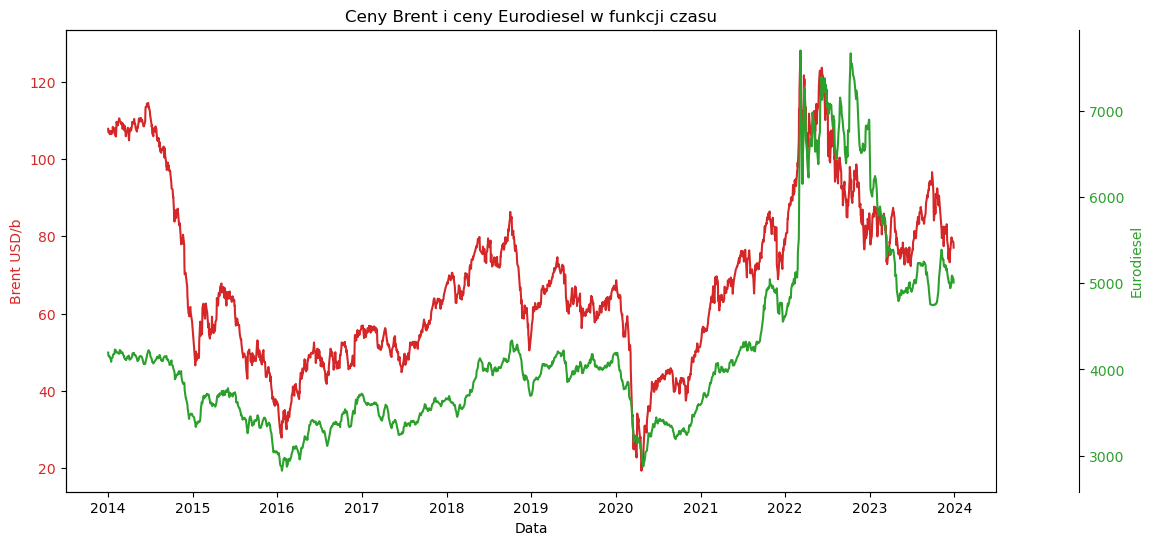

In [14]:
# Create a summary chart of the data
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Brent USD/b', color=color)
ax1.plot(merged_df['Brent USD/b'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 60))      
ax2.set_ylabel('Eurodiesel', color=color)
ax2.plot(merged_df['Eurodiesel'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Ceny Brent i ceny Eurodiesel w funkcji czasu')

plt.show()

In [15]:
# Analysis of correlations between data series throughout the study period
macierz_korelacji = merged_df.corr()
macierz_korelacji

,Brent USD/b,PLN/USD,Eurodiesel
Brent USD/b,1.000000,-0.035190,0.742698
PLN/USD,-0.035190,1.000000,0.588833
Eurodiesel,0.742698,0.588833,1.000000


In [16]:
# Conversion of Brent crude oil barrel prices to PLN
brent_PLN = merged_df.copy()
brent_PLN['Brent PLN/b'] = brent_PLN['Brent USD/b'] * brent_PLN['PLN/USD']
brent_PLN

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Data,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400
2023-12-28,78.39,3.8990,5049.0,305.642610
2023-12-22,79.07,3.9338,5090.0,311.045566
2023-12-21,79.39,3.9645,5082.0,314.741655
2023-12-20,79.70,3.9527,5039.0,315.030190
...,...,...,...,...
2014-01-10,107.25,3.0700,4136.0,329.257500
2014-01-09,106.39,3.0695,4150.0,326.564105
2014-01-08,107.15,3.0717,4146.0,329.132655


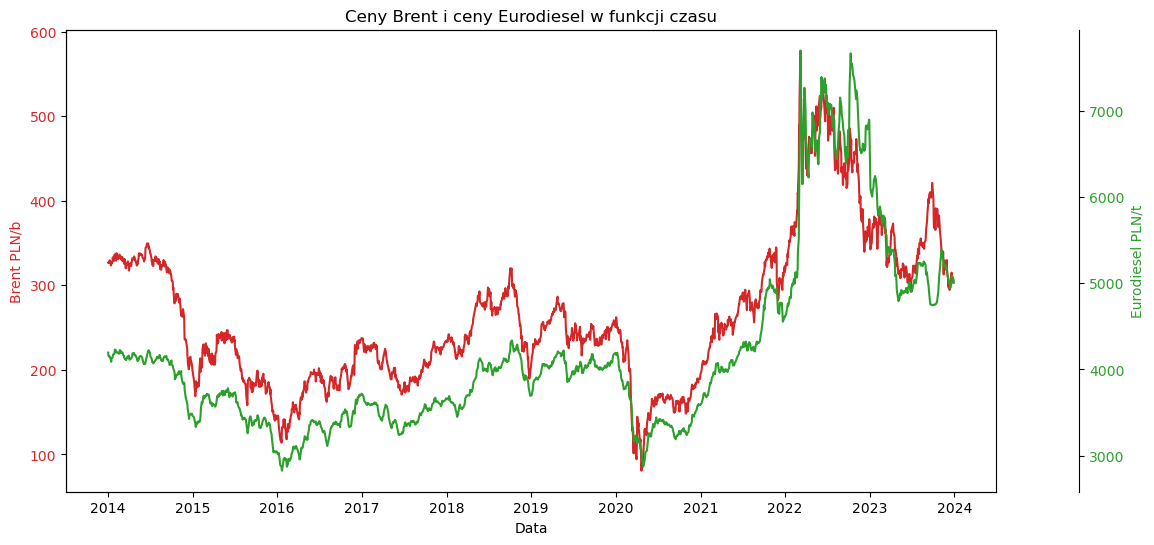

In [17]:
# Visualization of brent oil and eurodiesel price waveforms as a function of time
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Brent PLN/b', color=color)
ax1.plot(brent_PLN['Brent PLN/b'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 60))      
ax2.set_ylabel('Eurodiesel PLN/t', color=color)
ax2.plot(brent_PLN['Eurodiesel'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Ceny Brent i ceny Eurodiesel w funkcji czasu')

plt.show()

In [18]:
# Analysis of correlations between data series throughout the study period
macierz_korelacji_2 = brent_PLN.corr()
macierz_korelacji_2

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Brent USD/b,1.000000,-0.035190,0.742698,0.920090
PLN/USD,-0.035190,1.000000,0.588833,0.350902
Eurodiesel,0.742698,0.588833,1.000000,0.927633
Brent PLN/b,0.920090,0.350902,0.927633,1.000000


In [19]:
brent_PLN.head()

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Data,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400
2023-12-28,78.39,3.8990,5049.0,305.642610
2023-12-22,79.07,3.9338,5090.0,311.045566
2023-12-21,79.39,3.9645,5082.0,314.741655
2023-12-20,79.70,3.9527,5039.0,315.030190


## 4. Development of a model to predict Eurodiesel prices based on the PLN brent oil rate

### 4.1 Preparation of data for modeling
Preparation includes assigning data to variables and labels and dividing them for the teaching and testing set.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
sorted_brent_PLN = brent_PLN.sort_index()

In [22]:
base_brent_PLN = sorted_brent_PLN[:'2021-12-31'].copy()
base_brent_PLN

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Data,,,,
2014-01-02,107.78,3.0315,4196.0,326.735070
2014-01-03,106.89,3.0517,4160.0,326.196213
2014-01-08,107.15,3.0717,4146.0,329.132655
2014-01-09,106.39,3.0695,4150.0,326.564105
2014-01-10,107.25,3.0700,4136.0,329.257500
...,...,...,...,...
2021-12-22,75.29,4.0984,4554.0,308.568536
2021-12-23,76.85,4.0950,4561.0,314.700750
2021-12-24,76.14,4.0785,4565.0,310.536990


In [23]:
# Division of data into independent variables 'X' and dependent variable 'y'
X = base_brent_PLN[['Brent PLN/b']]  
y = base_brent_PLN['Eurodiesel']  


In [24]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.2 Modeling by linear regression

In [25]:
# Construction of a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [26]:
# Predicting on a test set
y_pred = model.predict(X_test)

In [27]:
# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MSE: 32689.02439504536
R2 Score: 0.822804108376685


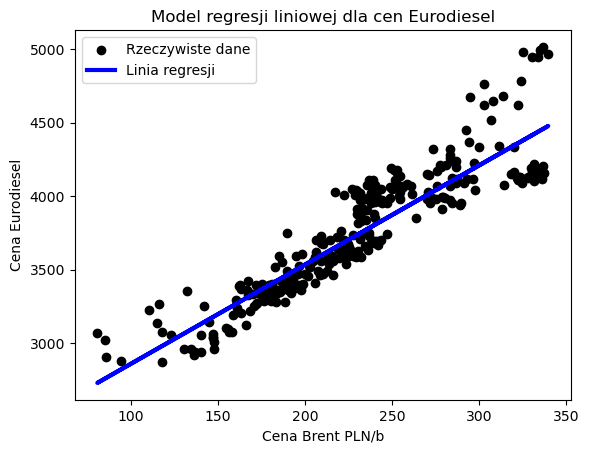

In [28]:
import matplotlib.pyplot as plt

# Scatter plot of test data
plt.scatter(X_test, y_test, color='black', label='Rzeczywiste dane')

# Line of regression
plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Linia regresji')

plt.title('Model regresji liniowej dla cen Eurodiesel')
plt.xlabel('Cena Brent PLN/b')
plt.ylabel('Cena Eurodiesel')

plt.legend()
plt.show()


In [29]:
brent_PLN_2022 = brent_PLN['2021-12-20':].copy()
brent_PLN_2022

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Data,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400
2023-12-28,78.39,3.8990,5049.0,305.642610
2023-12-22,79.07,3.9338,5090.0,311.045566
2023-12-21,79.39,3.9645,5082.0,314.741655
2023-12-20,79.70,3.9527,5039.0,315.030190
...,...,...,...,...
2021-12-24,76.14,4.0785,4565.0,310.536990
2021-12-23,76.85,4.0950,4561.0,314.700750
2021-12-22,75.29,4.0984,4554.0,308.568536


In [30]:
# Evaluation of model performance on data from 2022
X_predict = brent_PLN_2022[['Brent PLN/b']]
predicted_eurodiesel_prices = model.predict(X_predict)
brent_PLN_2022['Predicted Eurodiesel Price'] = predicted_eurodiesel_prices
brent_PLN_2022

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b,Predicted Eurodiesel Price
Data,,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400,4230.158429
2023-12-28,78.39,3.8990,5049.0,305.642610,4246.963342
2023-12-22,79.07,3.9338,5090.0,311.045566,4283.424607
2023-12-21,79.39,3.9645,5082.0,314.741655,4308.367265
2023-12-20,79.70,3.9527,5039.0,315.030190,4310.314412
...,...,...,...,...,...
2021-12-24,76.14,4.0785,4565.0,310.536990,4279.992537
2021-12-23,76.85,4.0950,4561.0,314.700750,4308.091222
2021-12-22,75.29,4.0984,4554.0,308.568536,4266.708638


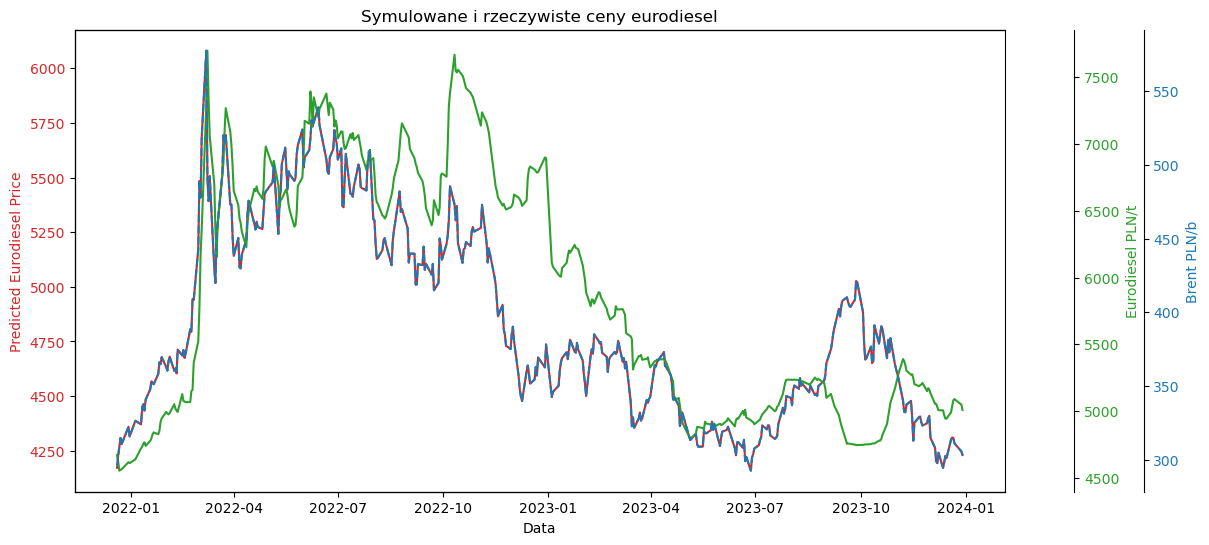

In [31]:
# Create a comparative chart of model and actual data
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Predicted Eurodiesel Price', color=color)
ax1.plot(brent_PLN_2022['Predicted Eurodiesel Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 50))      
ax2.set_ylabel('Eurodiesel PLN/t', color=color)
ax2.plot(brent_PLN_2022['Eurodiesel'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
ax3.set_xlabel('Data')
color = 'tab:blue'
ax3.spines['right'].set_position(('outward', 100))
ax3.set_ylabel('Brent PLN/b', color=color)
ax3.plot(brent_PLN_2022['Brent PLN/b'], color=color, linestyle='--')
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Symulowane i rzeczywiste ceny eurodiesel')

plt.show()

Analiza powyższego wykresu wskazuje, że w okresie 11.2022-01.2023 oraz 09.2023-11.2023 ceny paliwa Eurodiesel znacząco odbiegają od cen ropy brent oraz wartości modelowych. Mogłoby to wskazywać na pozarynkowe przyczyny poziomu cen.

<Axes: xlabel='Data'>

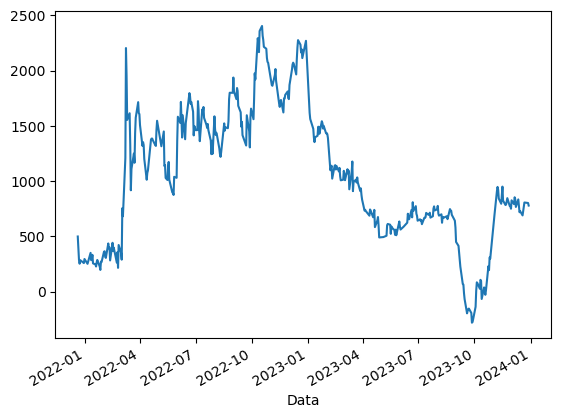

In [32]:
# Calculation of residuals
brent_PLN_2022['Residuals'] = brent_PLN_2022['Eurodiesel'] - brent_PLN_2022['Predicted Eurodiesel Price']
brent_PLN_2022['Residuals'].plot()

In [33]:
residuals_std_dev = np.std(brent_PLN_2022['Residuals'])
mean = np.mean(brent_PLN_2022['Residuals'])
brent_PLN_2022['Anomaly'] = brent_PLN_2022['Residuals'].apply(
    lambda x: 'Anomaly' if np.abs(x - mean) > 2 * residuals_std_dev else 'Normal')

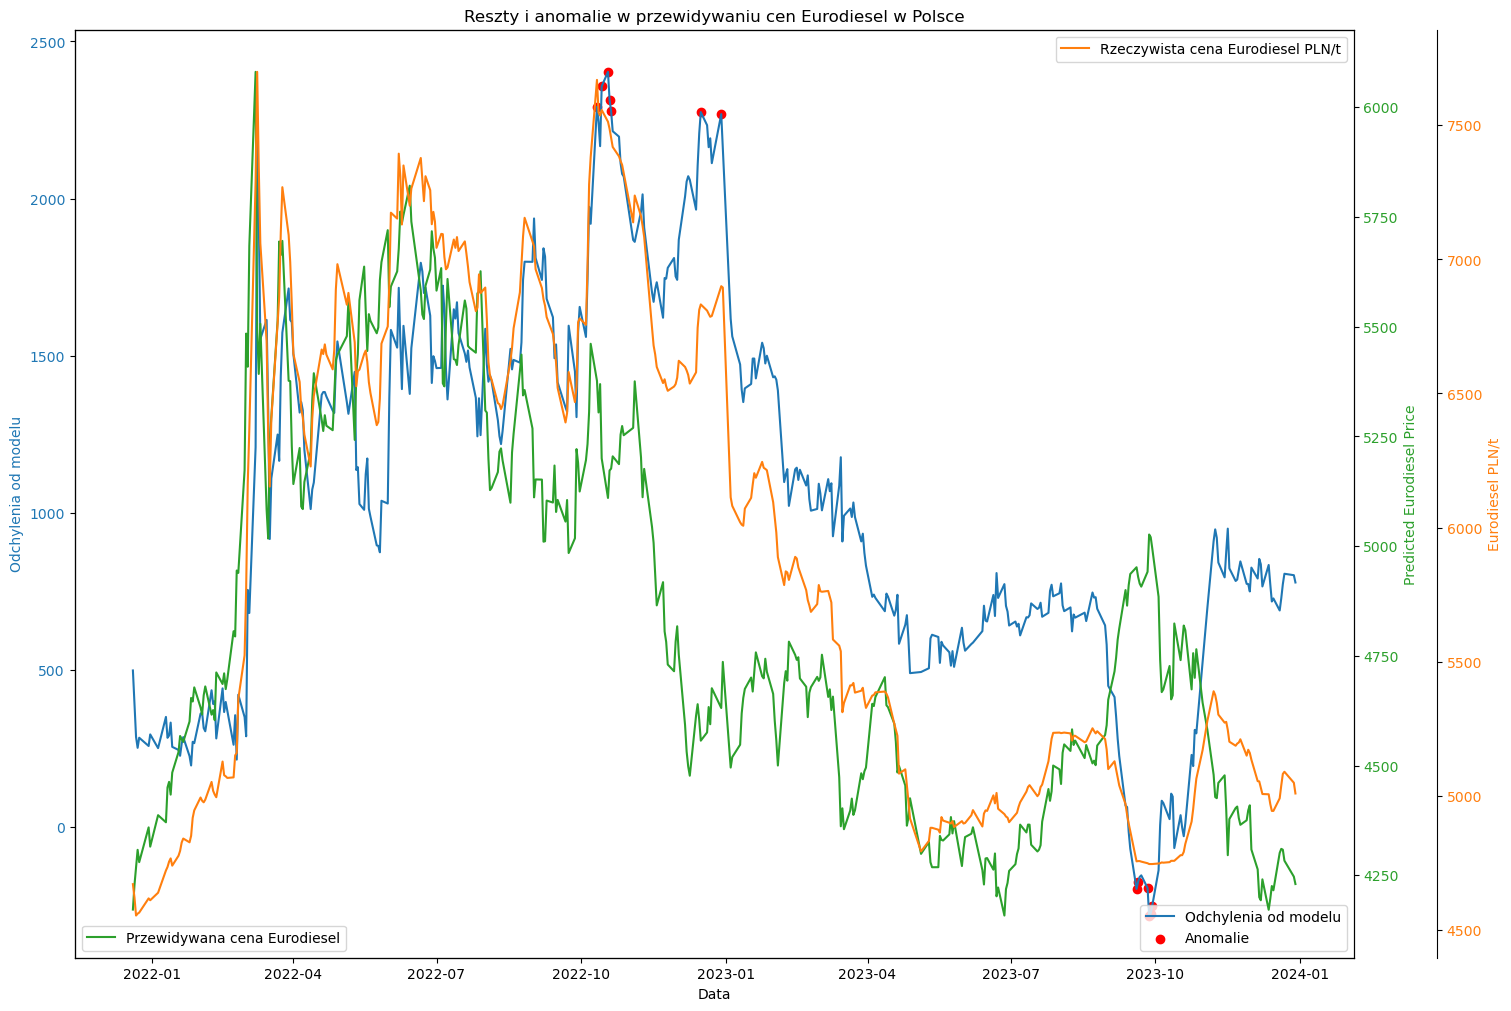

In [34]:
# Visualization of deviations from model, model prices and actual prices of Eurodiesel fuel
import matplotlib.pyplot as plt

anomalies = brent_PLN_2022[brent_PLN_2022['Anomaly'] == 'Anomaly']
fig, ax1 = plt.subplots(figsize=(15, 10), constrained_layout=True)

color = 'tab:blue'
ax1.set_xlabel('Data')
ax1.set_ylabel('Odchylenia od modelu', color=color)
ax1.plot(brent_PLN_2022.index, brent_PLN_2022['Residuals'], color=color, label = 'Odchylenia od modelu')
ax1.tick_params(axis='y', labelcolor=color)

# Addition of scatter plot for anomalies
ax1.scatter(anomalies.index, anomalies['Residuals'], color='red', label='Anomalie')

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Predicted Eurodiesel Price', color=color)
ax2.plot(brent_PLN_2022.index, brent_PLN_2022['Predicted Eurodiesel Price'], color=color, label = 'Przewidywana cena Eurodiesel')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:orange'
ax3.spines['right'].set_position(('outward', 60))      
ax3.set_ylabel('Eurodiesel PLN/t', color=color)
ax3.plot(brent_PLN_2022.index, brent_PLN_2022['Eurodiesel'], color=color, label = 'Rzeczywista cena Eurodiesel PLN/t')
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Reszty i anomalie w przewidywaniu cen Eurodiesel w Polsce')
 

ax1.legend(loc='lower right')  
ax2.legend(loc='lower left')  
ax3.legend(loc='upper left', bbox_to_anchor=(1.15, 1))

plt.legend()
plt.show()

### 4.3 Polynomial modeling
To verify the results based on the linear model, an analysis using a polynomial model will be carried out. However, in order to optimally tune the amount of data to be learned and the complexity of the model, a learning curve and a model validation curve will first be defined.

#### 4.3.1 Development of a learning curve

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.pipeline import Pipeline

In [36]:
# Preparation of polynomial data for the entire dataset
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

In [37]:
# Generation of learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=LinearRegression(), X=X_poly, y=y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')

In [38]:
# Calculation of mean and standard deviation for training and validation results
train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
validation_scores_std = validation_scores.std(axis=1)

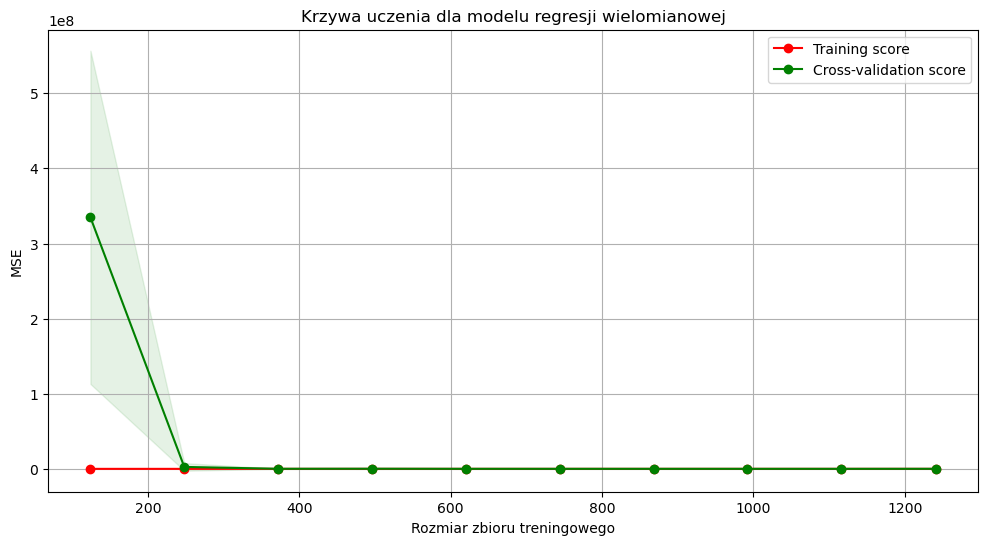

In [39]:
# Drawing learning curves
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.title("Krzywa uczenia dla modelu regresji wielomianowej")
plt.xlabel("Rozmiar zbioru treningowego")
plt.ylabel("MSE")
plt.legend(loc="best")
plt.grid()
plt.show()

#### 4.3.2 Development of a validation curve

In [40]:
# Selection of the degree of the polynomial as a parameter for testing
param_range = np.arange(1, 10)  

# Generation of a validation curve
train_scores, test_scores = validation_curve(
    estimator=Pipeline([("poly", PolynomialFeatures()), ("linear", LinearRegression())]),
    X=X, y=y,
    param_name="poly__degree",  
    param_range=param_range,    
    cv=5,                      
    scoring="neg_mean_squared_error", 
    n_jobs=-1               
)

In [41]:
# Calculation of mean and standard deviation for training and test results
train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -test_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
validation_scores_std = test_scores.std(axis=1)

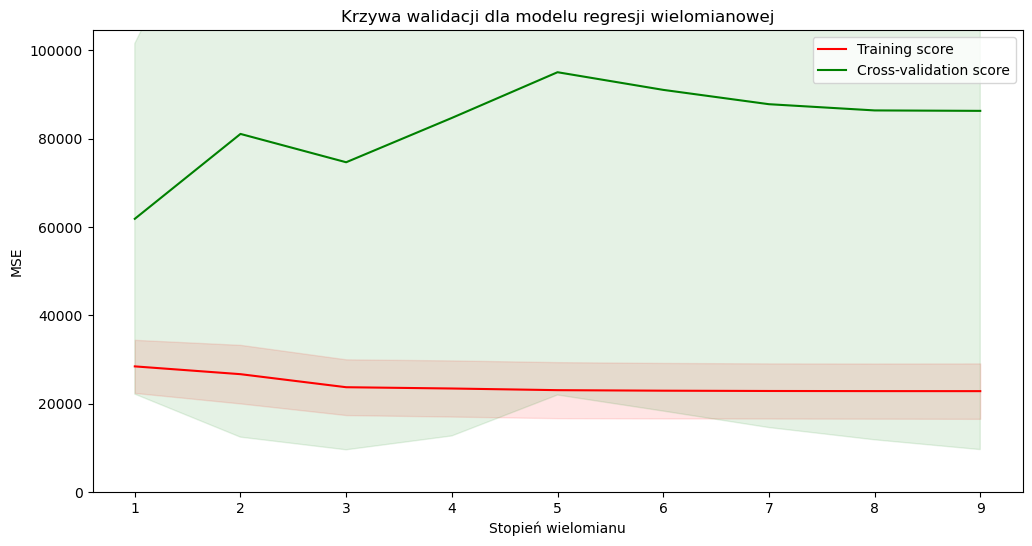

In [42]:
# Drawing a validation curve
plt.figure(figsize=(12, 6))
plt.title("Krzywa walidacji dla modelu regresji wielomianowej")
plt.xlabel("Stopień wielomianu")
plt.ylabel("MSE")
plt.ylim(0, max(train_scores_mean.max(), validation_scores_mean.max()) * 1.1)  # Dostosuj górny limit osi y
plt.xticks(param_range)
plt.plot(param_range, train_scores_mean, label="Training score", color="red")
plt.plot(param_range, validation_scores_mean, label="Cross-validation score", color="green")

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.legend(loc="best")
plt.show()

On the basis of the analyses carried out on the complexity of the model and its predictive ability, it was decided to opt for a 3rd degree polynomial model.

#### 4.3.3 Performing polynomial modelling

In [43]:
# Model preparation
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

In [44]:
# Training the model
poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)

LinearRegression()

In [45]:
# Predicting on a test set
y_poly_pred = poly_model.predict(X_poly_test)

In [46]:
# Model evaluation
poly_mse = mean_squared_error(y_test, y_poly_pred)
poly_r2 = r2_score(y_test, y_poly_pred)

print(f"MSE: {poly_mse}")
print(f"R^2: {poly_r2}")

MSE: 29054.129742135716
R^2: 0.8425076147033151


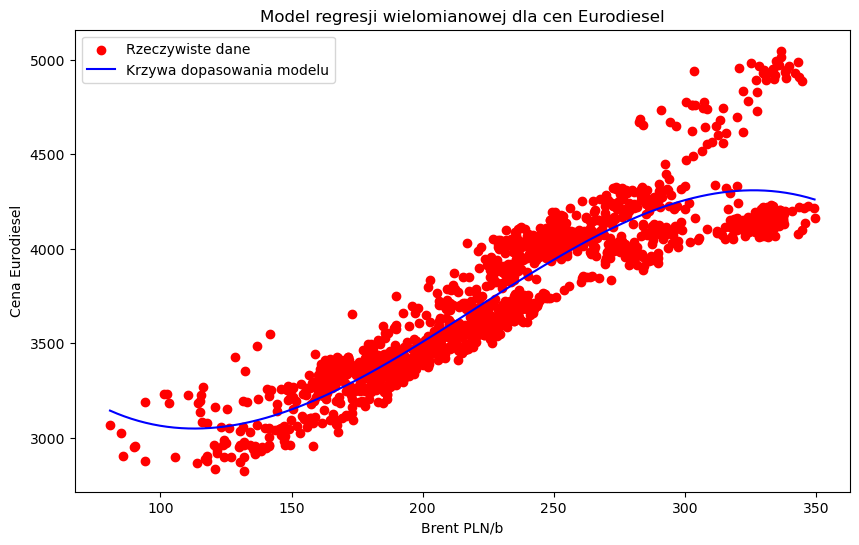

In [47]:
# Visualisation of the fitting curve of a polynomial model 
X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_fit_df = pd.DataFrame(X_fit, columns=['Brent PLN/b'])
X_fit_transformed = poly.transform(X_fit_df)
y_fit = poly_model.predict(X_fit_transformed)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='red', label='Rzeczywiste dane') 
plt.plot(X_fit, y_fit, color='blue', label='Krzywa dopasowania modelu')
plt.title('Model regresji wielomianowej dla cen Eurodiesel')
plt.xlabel('Brent PLN/b')
plt.ylabel('Cena Eurodiesel')
plt.legend()
plt.show()

In [48]:
eurodiesel_predict = brent_PLN['2022-01-05':].copy()

In [49]:
# Evaluation of polynominal model performance on data from 2022
X_new_data = eurodiesel_predict[['Brent PLN/b']].values
X_poly_predict = poly.transform(X_new_data)
predicted_poly_eurodiesel_prices = poly_model.predict(X_poly_predict)
eurodiesel_predict['Predicted Eurodiesel Price'] = predicted_poly_eurodiesel_prices
eurodiesel_predict

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b,Predicted Eurodiesel Price
Data,,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400,4267.659012
2023-12-28,78.39,3.8990,5049.0,305.642610,4275.763217
2023-12-22,79.07,3.9338,5090.0,311.045566,4290.450691
2023-12-21,79.39,3.9645,5082.0,314.741655,4298.113005
2023-12-20,79.70,3.9527,5039.0,315.030190,4298.626816
...,...,...,...,...,...
2022-01-13,84.47,3.9463,4767.0,333.343961,4304.269837
2022-01-12,84.67,3.9879,4755.0,337.655493,4297.294586
2022-01-11,83.72,4.0106,4735.0,335.767432,4300.763290


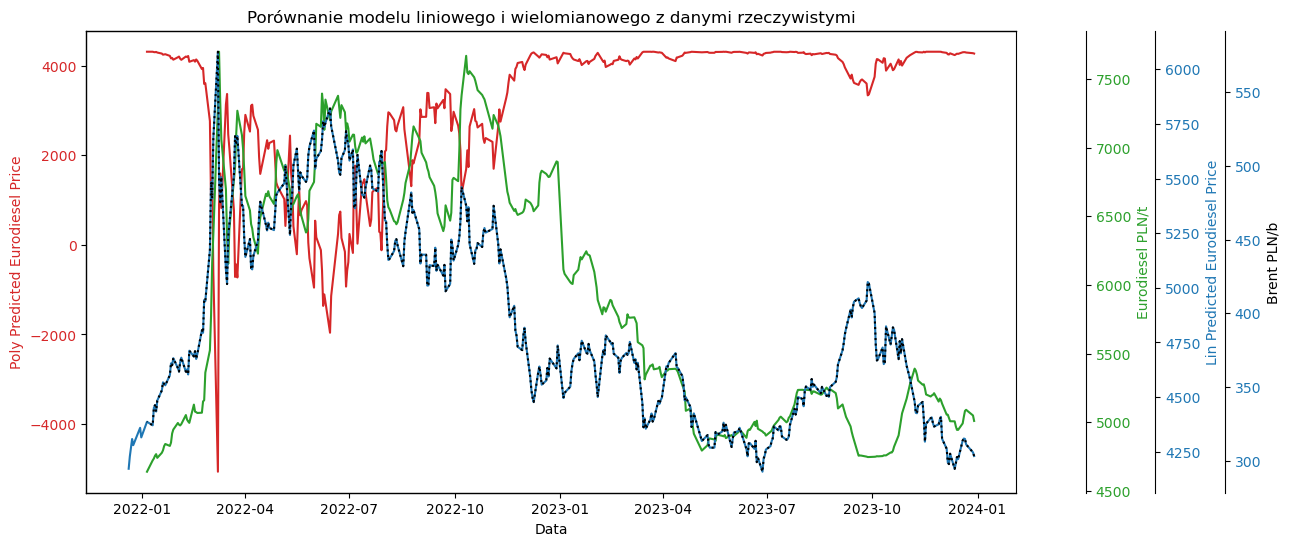

In [50]:
# Create a comparative chart of model and actual data
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Poly Predicted Eurodiesel Price', color=color)
ax1.plot(eurodiesel_predict['Predicted Eurodiesel Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 50))      
ax2.set_ylabel('Eurodiesel PLN/t', color=color)
ax2.plot(eurodiesel_predict['Eurodiesel'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
ax3.set_xlabel('Data')
color = 'tab:blue'
ax3.spines['right'].set_position(('outward', 100))
ax3.set_ylabel('Lin Predicted Eurodiesel Price', color=color)
ax3.plot(brent_PLN_2022['Predicted Eurodiesel Price'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax1.twinx()
ax4.set_xlabel('Data')
ax4.spines['right'].set_position(('outward', 150))
ax4.set_ylabel('Brent PLN/b', color='black')
ax4.plot(eurodiesel_predict['Brent PLN/b'], color='black', linestyle='dotted')
ax4.tick_params(axis='y', labelcolor=color)

plt.title('Porównanie modelu liniowego i wielomianowego z danymi rzeczywistymi')

plt.show()

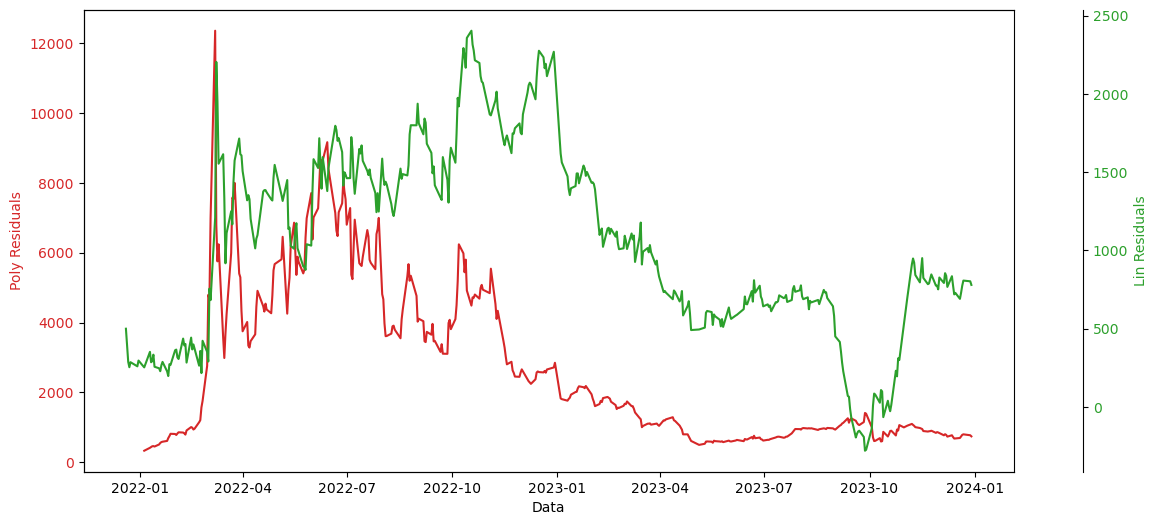

In [51]:
# Calculation of residuals
eurodiesel_predict['Residuals'] = eurodiesel_predict['Eurodiesel'] - eurodiesel_predict['Predicted Eurodiesel Price']
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Poly Residuals', color=color)
ax1.plot(eurodiesel_predict['Residuals'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 50))      
ax2.set_ylabel('Lin Residuals', color=color)
ax2.plot(brent_PLN_2022['Residuals'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

Validation of the model on the dataset from 01.2022 - 12-2023 does not give good prediction quality. The results obtained are too low to be considered correct. This may be due to the high volatility of the brent oil price after the outbreak of war in Ukraine in February 2022. In view of this, steps will be taken to validate the model on smaller data ranges from shorter time periods. This takes into account that there are periods in 2022-2023 where Eurodiesel prices may have been driven by non-market reasons, and therefore these periods will also be identified separately.
The periods for each stage of the analysis will be defined according to the following key:
- 01.01.2022-01.05.2022 - the period of the outbreak of war in Ukraine and sudden price increases, this will be excluded from the 'Wybuch wojny' analysis
- 01.06.2022-31.08.2022 - model validation period 'Walidacja modeli 1'
- 01.05.2023-31.08.2023 - model validation period 'Walidacja modeli 2'
- 01.09.2022-31.12.2022 - period containing market-unjustified Eurodiesel price levels 'Nieuzasadnione poziomy cen 1'
- 01.09.2023-15.10.2023 - period containing Eurodiesel price levels not justified by the market 'Nieuzasadnione poziomy cen 2'

### 4.4 Podział danych na okresy i walidacja modeli

In [52]:
periods_data = brent_PLN['2022-01-05':].copy()

def assign_period(row):
    if row.name <= pd.Timestamp('2022-05-01'):
        return 'Wybuch wojny'
    elif pd.Timestamp('2022-06-01') <= row.name <= pd.Timestamp('2022-08-31'):
        return 'Walidacja modeli 1'
    elif pd.Timestamp('2022-09-01') <= row.name <= pd.Timestamp('2022-12-31'):
        return 'Nieuzasadnione poziomy cen 1'
    elif pd.Timestamp('2023-05-01') <= row.name <= pd.Timestamp('2023-08-31'):
        return 'Walidacja modeli 2'
    elif pd.Timestamp('2023-09-01') <= row.name <= pd.Timestamp('2023-10-15'):
        return 'Nieuzasadnione poziomy cen 2'
    else:
        return 'Inny okres'
    
periods_data['Period'] = periods_data.apply(assign_period, axis=1)
periods_data['Period'].value_counts()

Period
Inny okres                      120
Wybuch wojny                     65
Nieuzasadnione poziomy cen 1     64
Walidacja modeli 2               61
Walidacja modeli 1               52
Nieuzasadnione poziomy cen 2     25
Name: count, dtype: int64

In [53]:
# Validation of models for the period 'Walidacja modeli 1'
X_val_1 = periods_data['Brent PLN/b'].values.reshape(-1,1)
X_val_1_poly = poly.transform(X_val_1)
predicted_lin_val_1 = model.predict(X_val_1)
predicted_poly_val_1 = poly_model.predict(X_val_1_poly)
periods_data['Validation_1_lin'] = predicted_lin_val_1
periods_data['Validation_1_poly'] = predicted_poly_val_1
periods_data.head()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b,Period,Validation_1_lin,Validation_1_poly
Data,,,,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400,Inny okres,4230.158429,4267.659012
2023-12-28,78.39,3.8990,5049.0,305.642610,Inny okres,4246.963342,4275.763217
2023-12-22,79.07,3.9338,5090.0,311.045566,Inny okres,4283.424607,4290.450691
2023-12-21,79.39,3.9645,5082.0,314.741655,Inny okres,4308.367265,4298.113005
2023-12-20,79.70,3.9527,5039.0,315.030190,Inny okres,4310.314412,4298.626816


In [54]:
# Models evaluation for 'Walidacja modeli 1' period
validation_1_data = periods_data[periods_data['Period'] == 'Walidacja modeli 1']

# Actual Eurodiesel values
y_real_1 = validation_1_data['Eurodiesel']

# Predictions of the linear model for 'Walidacja modeli 1'
y_pred_lin_1 = validation_1_data['Validation_1_lin']

# Predictions of the polynomial model for 'Walidacja modeli 1'
y_pred_poly_1 = validation_1_data['Validation_1_poly']

# Calculation of MSE and R^2 for a linear model
lin_valid_1_mse = mean_squared_error(y_real_1, y_pred_lin_1)
lin_valid_1_r2 = r2_score(y_real_1, y_pred_lin_1)

# Calculation of MSE and R^2 for a polynominal model
poly_valid_1_mse = mean_squared_error(y_real_1, y_pred_poly_1)
poly_valid_1_r2 = r2_score(y_real_1, y_pred_poly_1)

print("Model liniowy - MSE:", lin_valid_1_mse, "R^2:", lin_valid_1_r2)
print("Model wielomianowy - MSE:", poly_valid_1_mse, "R^2:", poly_valid_1_r2)

Model liniowy - MSE: 2309345.896023318 R^2: -34.90502115353972
Model wielomianowy - MSE: 38956952.49848573 R^2: -604.6910772631388


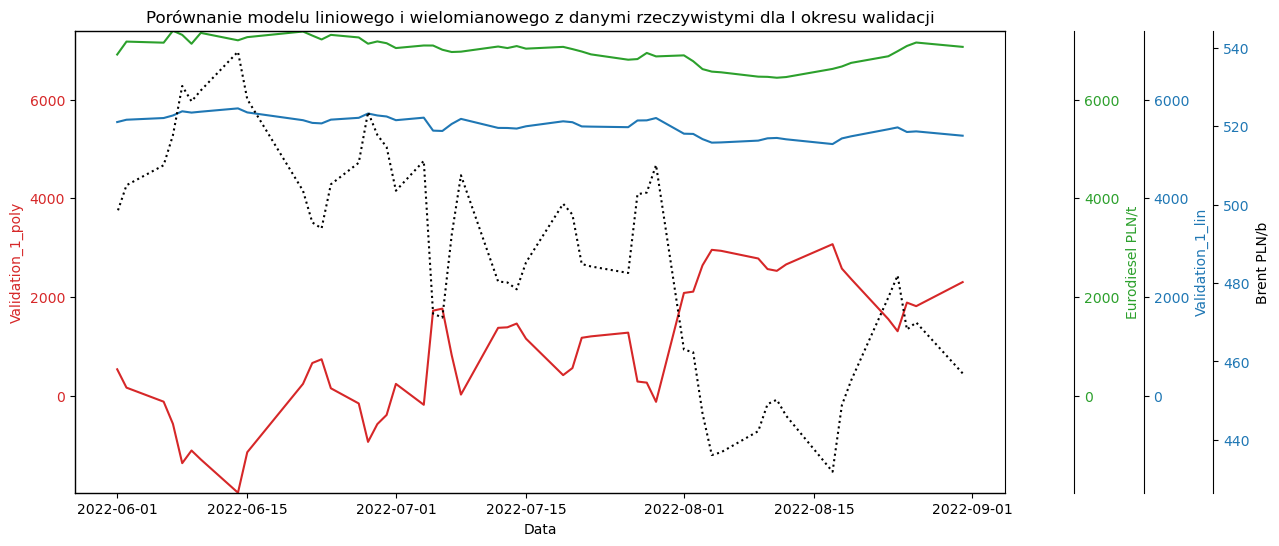

In [55]:
# Create a comparative chart of model and actual data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Determination of Y-axis range based on maximum and minimum values of selected data series
max_y_1 = max(validation_1_data['Validation_1_poly'].max(),
            validation_1_data['Eurodiesel'].max(),
            validation_1_data['Validation_1_lin'].max())
min_y_1 = min(validation_1_data['Validation_1_poly'].min(),
            validation_1_data['Eurodiesel'].min(),
            validation_1_data['Validation_1_lin'].min())

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Validation_1_poly', color=color)
ax1.plot(validation_1_data['Validation_1_poly'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([min_y_1, max_y_1])  

ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 50))      
ax2.set_ylabel('Eurodiesel PLN/t', color=color)
ax2.plot(validation_1_data['Eurodiesel'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([min_y_1, max_y_1])

ax3 = ax1.twinx()
ax3.set_xlabel('Data')
color = 'tab:blue'
ax3.spines['right'].set_position(('outward', 100))
ax3.set_ylabel('Validation_1_lin', color=color)
ax3.plot(validation_1_data['Validation_1_lin'], color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim([min_y_1, max_y_1])

ax4 = ax1.twinx()
ax4.set_xlabel('Data')
ax4.spines['right'].set_position(('outward', 150))
ax4.set_ylabel('Brent PLN/b', color='black')
ax4.plot(validation_1_data['Brent PLN/b'], color='black', linestyle='dotted')
ax4.tick_params(axis='y', labelcolor=color)

plt.title('Porównanie modelu liniowego i wielomianowego z danymi rzeczywistymi dla I okresu walidacji')

plt.show()

In [56]:
# Validation of models for the period 'Walidacja modeli 2'
X_val_2 = periods_data['Brent PLN/b'].values.reshape(-1,1)
X_val_2_poly = poly.transform(X_val_2)
predicted_lin_val_2 = model.predict(X_val_2)
predicted_poly_val_2 = poly_model.predict(X_val_2_poly)
periods_data['Validation_2_lin'] = predicted_lin_val_2
periods_data['Validation_2_poly'] = predicted_poly_val_2
periods_data.head()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b,Period,Validation_1_lin,Validation_1_poly,Validation_2_lin,Validation_2_poly
Data,,,,,,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400,Inny okres,4230.158429,4267.659012,4230.158429,4267.659012
2023-12-28,78.39,3.8990,5049.0,305.642610,Inny okres,4246.963342,4275.763217,4246.963342,4275.763217
2023-12-22,79.07,3.9338,5090.0,311.045566,Inny okres,4283.424607,4290.450691,4283.424607,4290.450691
2023-12-21,79.39,3.9645,5082.0,314.741655,Inny okres,4308.367265,4298.113005,4308.367265,4298.113005
2023-12-20,79.70,3.9527,5039.0,315.030190,Inny okres,4310.314412,4298.626816,4310.314412,4298.626816


In [57]:
# Models evaluation for 'Walidacja modeli 2' period

validation_2_data = periods_data[periods_data['Period'] == 'Walidacja modeli 2']
y_real_2 = validation_2_data['Eurodiesel']

y_pred_lin_2 = validation_2_data['Validation_2_lin']

y_pred_poly_2 = validation_2_data['Validation_2_poly']

lin_valid_2_mse = mean_squared_error(y_real_2, y_pred_lin_2)
lin_valid_2_r2 = r2_score(y_real_2, y_pred_lin_2)

poly_valid_2_mse = mean_squared_error(y_real_2, y_pred_poly_2)
poly_valid_2_r2 = r2_score(y_real_2, y_pred_poly_2)

print("Model liniowy - MSE:", lin_valid_2_mse, "R^2:", lin_valid_2_r2)
print("Model wielomianowy - MSE:", poly_valid_2_mse, "R^2:", poly_valid_2_r2)

Model liniowy - MSE: 436295.6487140106 R^2: -21.092918685393936
Model wielomianowy - MSE: 576516.4691215103 R^2: -28.193349763249504


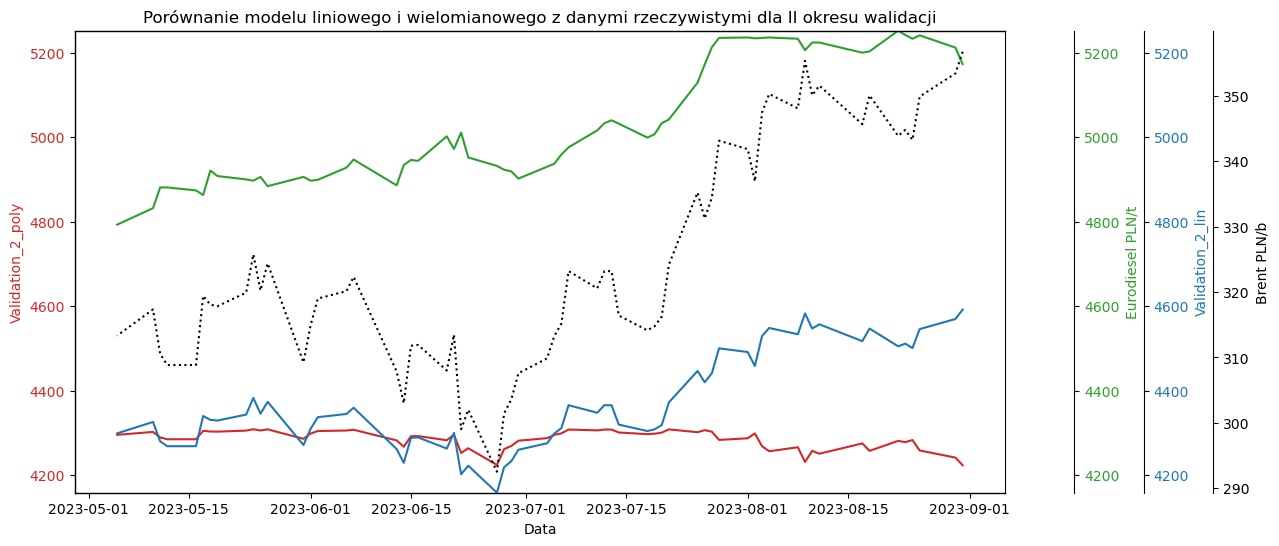

In [58]:
fig, ax1 = plt.subplots(figsize=(12, 6))

max_y = max(validation_2_data['Validation_2_poly'].max(),
            validation_2_data['Eurodiesel'].max(),
            validation_2_data['Validation_2_lin'].max())
min_y = min(validation_2_data['Validation_2_poly'].min(),
            validation_2_data['Eurodiesel'].min(),
            validation_2_data['Validation_2_lin'].min())
             

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Validation_2_poly', color=color)
ax1.plot(validation_2_data['Validation_2_poly'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([min_y, max_y])  

ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 50))      
ax2.set_ylabel('Eurodiesel PLN/t', color=color)
ax2.plot(validation_2_data['Eurodiesel'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([min_y, max_y])  

ax3 = ax1.twinx()
color = 'tab:blue'
ax3.spines['right'].set_position(('outward', 100))
ax3.set_ylabel('Validation_2_lin', color=color)
ax3.plot(validation_2_data['Validation_2_lin'], color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim([min_y, max_y])  

ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 150))
ax4.set_ylabel('Brent PLN/b', color='black')
ax4.plot(validation_2_data['Brent PLN/b'], color='black', linestyle='dotted')
ax4.tick_params(axis='y', labelcolor='black')

plt.title('Porównanie modelu liniowego i wielomianowego z danymi rzeczywistymi dla II okresu walidacji')

plt.show()

Validation results on periods considered stable are unsatisfactory. The linear model validation manifests symptoms of over-fitting to the data and its run appears to be analogous to brent oil prices. This correlates in part with the run of the actual Eurodiesel price, but the values differ significantly. 
The polynomial model, on the other hand, does not reflect trends in brent crude oil prices and its predictions of Eurodiesel prices are significantly different from actual values. Under certain conditions, its prediction indicates negative values, which is improbable in the case of fuel prices.
In view of the above, a different model should be developed, for the prediction of Eurodiesel prices, which will be used to determine potential non-market impacts on the price of this fuel.

### 4.5 Modelling using Random Forests 

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# To train and test the model, the 2014-2020 data sets created so far will be used.
# Creation of a random forest model with a defined number of trees and maximum depth
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Perform cross-validation on training data
cv_scores = cross_val_score(random_forest_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

mse_cv_scores = -cv_scores
average_mse_cv = np.mean(mse_cv_scores)

print(f'MSE scores from cross-validation: {mse_cv_scores}')
print(f'Average MSE from cross-validation: {average_mse_cv}')

# Training of the model on the entire training data set and evaluation on the test set
random_forest_model.fit(X_train, y_train)
y_pred_forest = random_forest_model.predict(X_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)
r2_forest = r2_score(y_test, y_pred_forest)

print(f'MSE on test set: {mse_forest}')
print(f'R² on test set: {r2_forest}')

feature_importances = random_forest_model.feature_importances_
print(f'Feature Importances: {feature_importances}')

MSE scores from cross-validation: [36605.15090833 27223.22969215 29321.82228503 31639.50735635
 27445.58793151]
Average MSE from cross-validation: 30447.059634675486
MSE on test set: 28447.854641487695
R² on test set: 0.8457940222672138
Feature Importances: [1.]


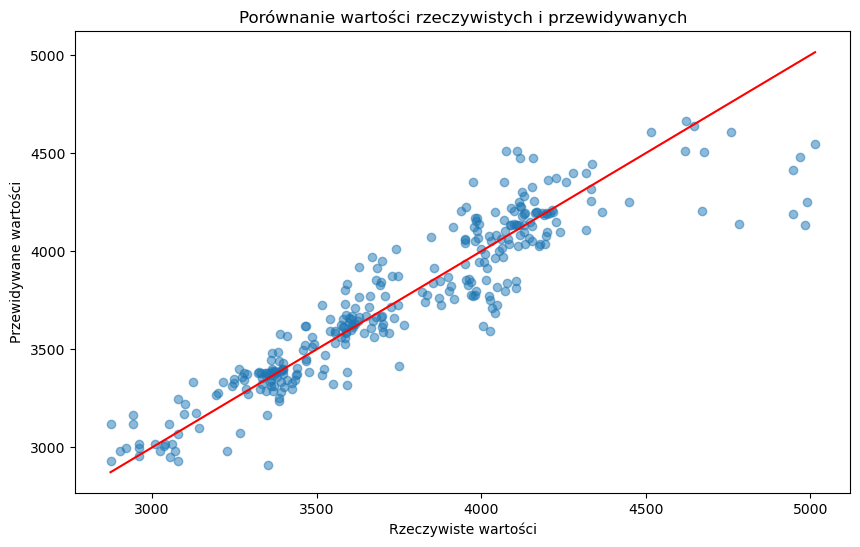

In [60]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_forest, alpha=0.5)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Porównanie wartości rzeczywistych i przewidywanych')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')  
plt.show()

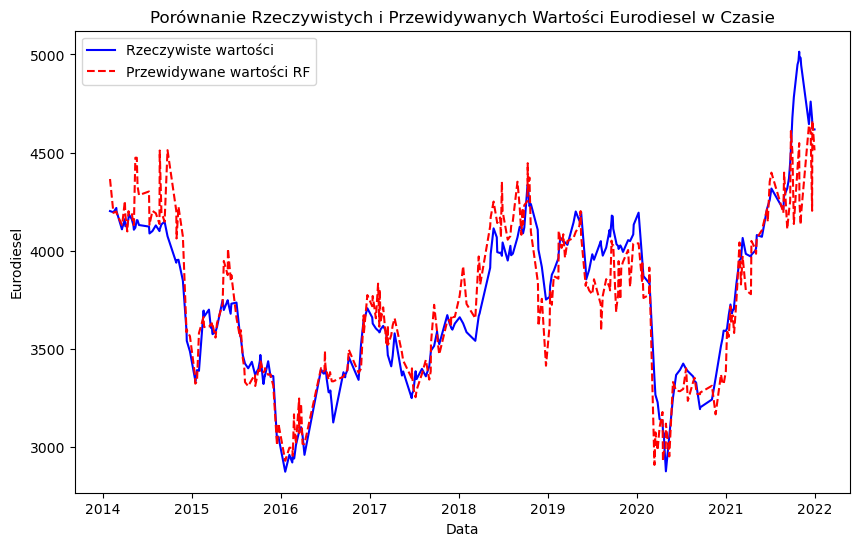

In [119]:
actual_values = y_test
predicted_values_RF = y_pred_forest
actual_values_series = pd.Series(actual_values, index=pd.to_datetime(actual_values.index))
predicted_values_RF_series = pd.Series(predicted_values_RF, index=actual_values_series.index)

actual_values_sorted = actual_values_series.sort_index()
predicted_values_RF_sorted = predicted_values_RF_series.sort_index()

plt.figure(figsize=(10, 6))
plt.plot(actual_values_sorted.index, actual_values_sorted, label='Rzeczywiste wartości', color='blue')
plt.plot(predicted_values_RF_sorted.index, predicted_values_RF_sorted, label='Przewidywane wartości RF', color='red', linestyle='--')
plt.title("Porównanie Rzeczywistych i Przewidywanych Wartości Eurodiesel w Czasie")
plt.xlabel("Data")
plt.ylabel("Eurodiesel")
plt.legend()
plt.show()

### 4.6 Wykorzystanie modelu ARIMAX

In [61]:
brent_PLN_2022.sort_index(inplace=True)

In [62]:
print(base_brent_PLN['Brent PLN/b'].isnull().sum()) 
print(brent_PLN_2022['Brent PLN/b'].isnull().sum()) 


0
0


In [63]:
base_brent_PLN

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Data,,,,
2014-01-02,107.78,3.0315,4196.0,326.735070
2014-01-03,106.89,3.0517,4160.0,326.196213
2014-01-08,107.15,3.0717,4146.0,329.132655
2014-01-09,106.39,3.0695,4150.0,326.564105
2014-01-10,107.25,3.0700,4136.0,329.257500
...,...,...,...,...
2021-12-22,75.29,4.0984,4554.0,308.568536
2021-12-23,76.85,4.0950,4561.0,314.700750
2021-12-24,76.14,4.0785,4565.0,310.536990


In [64]:
base_brent_PLN.index = pd.to_datetime(base_brent_PLN.index)

# Grouping of data by week and calculation of average for each week
weekly_mean_train = base_brent_PLN.resample('W').mean()

print(weekly_mean_train.head())

            Brent USD/b   PLN/USD  Eurodiesel  Brent PLN/b
Data                                                      
2014-01-05     107.3350  3.041600     4178.00   326.465642
2014-01-12     106.9300  3.070400     4144.00   328.318087
2014-01-19     106.7725  3.051425     4111.50   325.809009
2014-01-26     107.6150  3.070250     4159.75   330.404861
2014-02-02     107.4025  3.097950     4199.50   332.720647


In [97]:
# Checking the stationarity of endogenous data
from statsmodels.tsa.stattools import adfuller

result = adfuller(weekly_mean_train['Eurodiesel'])
print (f"ADS Statostics: {result[0]}")
print (f"p-value: {result[1]}")

ADS Statostics: -1.9613688857027107
p-value: 0.30376401348642573


In [98]:
print(brent_PLN_2022.dtypes)


Brent USD/b                   float64
PLN/USD                       float64
Eurodiesel                    float64
Brent PLN/b                   float64
Predicted Eurodiesel Price    float64
Residuals                     float64
Anomaly                        object
dtype: object


In [99]:
weekly1 = brent_PLN_2022.copy()
weekly1 = weekly1.drop(columns=['Anomaly'])
# Grouping of data by week and calculation of average for each week
weekly_mean_2022_test = weekly1.resample('W').mean()

print(weekly_mean_2022_test.head())

            Brent USD/b  PLN/USD  Eurodiesel  Brent PLN/b  \
Data                                                        
2021-12-26       74.756  4.09676     4594.40   306.238373   
2022-01-02       78.550  4.06155     4614.50   319.035946   
2022-01-09       80.800  4.03960     4639.00   326.399680   
2022-01-16       83.958  3.98218     4743.80   334.307247   
2022-01-23       88.055  3.98625     4809.75   351.011031   

            Predicted Eurodiesel Price   Residuals  
Data                                                
2021-12-26                 4250.983786  343.416214  
2022-01-02                 4337.346824  277.153176  
2022-01-09                 4387.040187  251.959813  
2022-01-16                 4440.403550  303.396450  
2022-01-23                 4553.127233  256.622767  


In [100]:
# Filling in NaN values with the average
mean_brent = weekly_mean_train['Brent PLN/b'].mean()
weekly_mean_train['Brent PLN/b'].fillna(mean_brent, inplace=True)
mean_eurodeisel = weekly_mean_train['Eurodiesel'].mean()
weekly_mean_train['Eurodiesel'].fillna(mean_brent, inplace=True)

In [101]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# shortening the period of training data to align the number of rows with the validation data
weekly_mean_train_adjusted = weekly_mean_train.loc[:weekly_mean_2022_test.index[0] - pd.Timedelta(days=1)]

# model traning
model = SARIMAX(
    endog=weekly_mean_train_adjusted['Eurodiesel'], 
    exog=weekly_mean_train_adjusted['Brent PLN/b'], 
    order=(1, 0, 1), 
    seasonal_order=(0, 0, 0, 0)
)
fitted_model = model.fit()

# Forecasting on validation data
forecast = fitted_model.predict(
    start=weekly_mean_2022_test.index[0], 
    end=weekly_mean_2022_test.index[-1], 
    exog=weekly_mean_2022_test['Brent PLN/b']
)

MSE: 68272.62559027615
R²: 0.6985511412585764


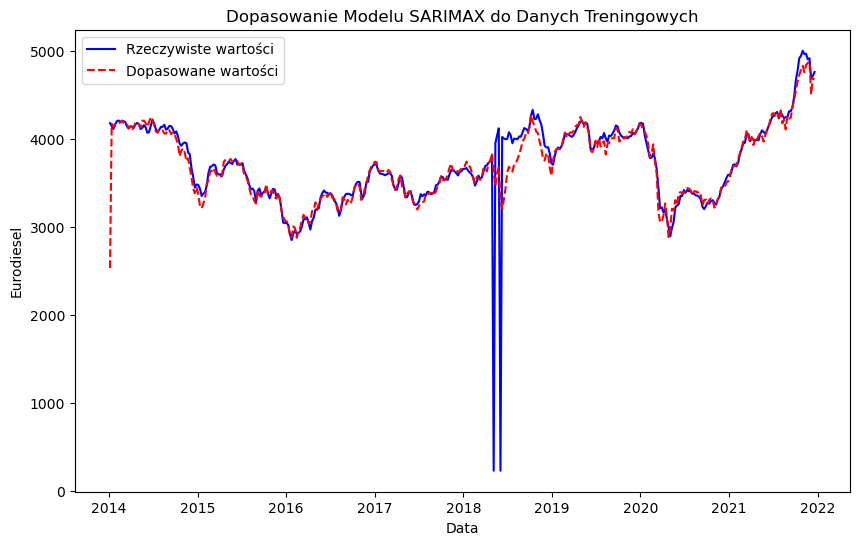

In [106]:
# Matched values from the model
fitted_values = fitted_model.fittedvalues

# Actual training values
actual_values = weekly_mean_train['Eurodiesel']

actual_values_aligned = actual_values[actual_values.index.isin(fitted_values.index)]

mse_sarimax_train = mean_squared_error(actual_values_aligned, fitted_values)
r2_sarimax_train = r2_score(actual_values_aligned, fitted_values)

print(f"MSE: {mse_sarimax_train}")
print(f"R²: {r2_sarimax_train}")

plt.figure(figsize=(10, 6))
plt.plot(actual_values_aligned.index, actual_values_aligned, label='Rzeczywiste wartości', color='blue')
plt.plot(fitted_values.index, fitted_values, label='Dopasowane wartości', color='red', linestyle='--')
plt.title("Dopasowanie Modelu SARIMAX do Danych Treningowych")
plt.xlabel("Data")
plt.ylabel("Eurodiesel")
plt.legend()
plt.show()


In [109]:
low_values = actual_values_aligned[actual_values_aligned < 1000]
print (low_values)

Data
2018-05-06    230.519622
2018-06-03    230.519622
Name: Eurodiesel, dtype: float64


MSE: 19551.76323835449
R²: 0.8836111358129434


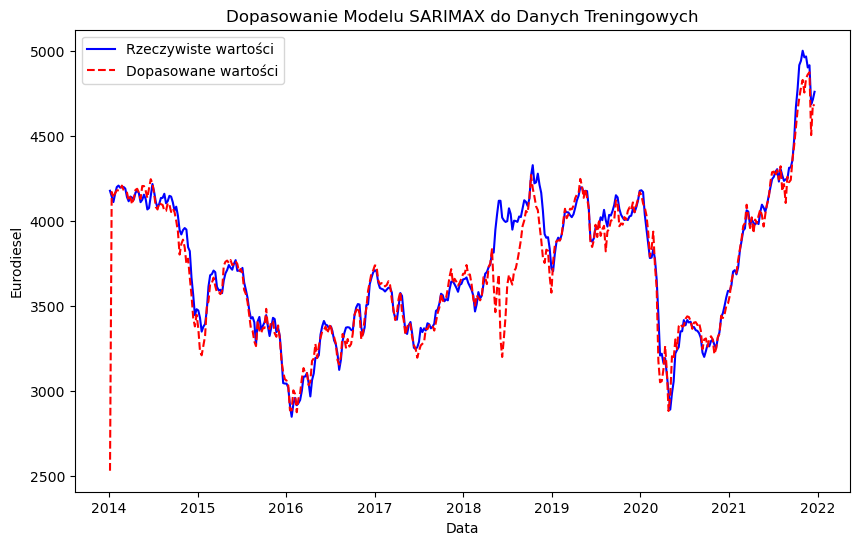

In [112]:
# Replacement of values less than 1000 by the previous week's price
for i in range(1, len(actual_values_aligned)):
    if actual_values_aligned.iloc[i] < 1000:
        actual_values_aligned.iloc[i] = actual_values_aligned.iloc[i - 1]

mse_sarimax_train = mean_squared_error(actual_values_aligned, fitted_values)
r2_sarimax_train = r2_score(actual_values_aligned, fitted_values)

print(f"MSE: {mse_sarimax_train}")
print(f"R²: {r2_sarimax_train}")

# Wykres
plt.figure(figsize=(10, 6))
plt.plot(actual_values_aligned.index, actual_values_aligned, label='Rzeczywiste wartości', color='blue')
plt.plot(fitted_values.index, fitted_values, label='Dopasowane wartości', color='red', linestyle='--')
plt.title("Dopasowanie Modelu SARIMAX do Danych Treningowych")
plt.xlabel("Data")
plt.ylabel("Eurodiesel")
plt.legend()
plt.show()

## 5. Summary
Historical brent crude oil prices, USD/PLN exchange rate and Eurodiesel fuel prices were used in the project. An analysis was carried out to demonstrate non-market influences on Eurodiesel fuel prices. Several predictive models were used for this purpose:
- The linear model showed an over-fitting and reproduced almost 1:1 changes in brent oil prices. 
- The polynomial model showed illogical values (fuel prices below 0 PLN) and its convergence with training and test data was also unsatisfactory. 
- The random forest model showed too much variance on the training data, its fit was not satisfactory and it could not be used to assess price changes over the test period,
- The ARIMAX model showed a reasonable fit to the training data, and the validation results on the test data suggest possible influences of non-market factors on Eurodiesel fuel price formation, especially in the last period of 2022 and also in the period September-October 2023.

